In [1]:
import gymnasium as gym
from tqdm.notebook import trange
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
def create_policy_network():
    return torch.nn.Sequential(
        torch.nn.Linear(4, 150),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(150, 2),
        torch.nn.Softmax(dim=0)
    )

In [3]:
def discount_rewards(rewards, discount_factor):
    ret = torch.pow(discount_factor, torch.arange(len(rewards)).float()) * rewards
    return ret / torch.max(ret)

In [4]:
def loss_fn(action_probs, disc_rewards):
    return -1 * torch.sum(disc_rewards * torch.log(action_probs))

In [5]:
def filter_timeseries(ts, p):
    tsf = np.nan * np.ones_like(ts)
    prev = ts[0]
    for i, v in enumerate(ts):
        tsf[i] = prev = p * prev + (1-p) * v
    return tsf

In [6]:
def compute_loss(loss_function, experience):
    states = torch.Tensor([s for (s, a, r) in experience])
    # states = torch.Tensor(np.vstack([s for (s, a, r) in experience]))
    actions = torch.Tensor([a for (s, a, r) in experience])
    rewards = np.array([r for (s, a, r) in experience])
    rewards = [np.sum(rewards[i:]) for i in range(len(rewards))]
    rewards = torch.Tensor(rewards)
    # ----
    rewards_disc = discount_rewards(rewards, gamma)
    predictions = model(states)
    probs = predictions.gather(dim=1, index=actions.long().view(-1, 1)).squeeze()
    return loss_function(probs, rewards_disc)


In [7]:
def choose_action(model, state):
    probs = model(torch.from_numpy(state).float())
    return np.random.choice(possible_actions, p=probs.data.numpy())

In [8]:
def take_action(game, action):
    state, reward, terminated, truncated, _ = game.step(action)
    done = terminated or truncated
    return state, reward, done

In [9]:
model = create_policy_network()

In [10]:
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
MAX_DURATION = 250
EPISODES = 500
gamma = 0.99

In [18]:
env = gym.make("CartPole-v1")
possible_actions = np.array([0, 1])
scores = []
for episode_ndx in trange(EPISODES):
    s, _ = env.reset()

    episode = []
    for t in range(MAX_DURATION):
        a = choose_action(model, s)
        s_new, r, terminate = take_action(env, a)
        # episode.append((s, a, t + 1))
        episode.append((s, a, r))
        s = s_new
        if terminate:
            break

    scores.append(len(episode))
    loss = compute_loss(loss_fn, episode)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  0%|          | 0/500 [00:00<?, ?it/s]

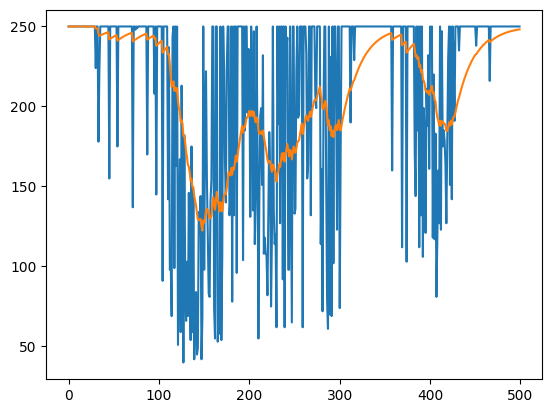

In [19]:
scores = np.array(scores)
filtered = filter_timeseries(scores, 0.95)
data = np.zeros((len(scores), 2))
data[:,0] = scores
data[:,1] = filtered
plt.plot(data)

In [22]:
env = gym.make("CartPole-v1")
possible_actions = np.array([0, 1])

scores = []
for episode_ndx in trange(EPISODES):
    s, _ = env.reset()

    for t in range(2*MAX_DURATION):
        probs = model(torch.from_numpy(s).float())
        a = torch.argmax(probs)
        s_new, _, terminated, truncated, _ = env.step(a.item())
        terminate = terminated or truncated
        s = s_new
        if terminate:
            break

    scores.append(t)

  0%|          | 0/500 [00:00<?, ?it/s]

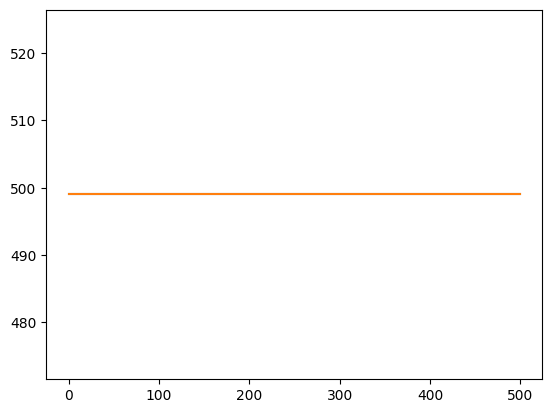

In [23]:
scores = np.array(scores)
filtered = filter_timeseries(scores, 0.95)
data = np.zeros((len(scores), 2))
data[:,0] = scores
data[:,1] = filtered
plt.plot(data)